# Neanderthal ancestry estimates on different subsets of sites

The idea is to take the sets of SNPs ascertained in non-Africans vs Africans and check for potential biases...

Moreover, the number of SNPs ascertained in each panel is so low, that there are barely any informative ABBA/BABA sites. For example, a panel of 100k SNPs ascertained in a single French individual will contain only ~2% of sites shared with the Neanderthals and which are then informative (show the ABBA or BABA pattern). If we take then another French individual, he or she will have most likely a different 2% of the genome of Nea origin and so that H.O. panel will be barely informative about Nea. ancestry.

In [2]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../code/utils.R")

})

In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [4]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

In [5]:
EIGENSTRAT_DIR <- "../data/eigenstrat/bigyri_ho/"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "all.ind")

In [5]:
file.copy("/mnt/expressions/alexh/SGDP_HumanOrigins/info/annotation.hg19.txt", "../data/annotation.hg19.txt")

[1] FALSE

In [6]:
suppressWarnings(suppressMessages({

ho_snps <- read_table2("../data/annotation.hg19.txt", comment="##") %>%
    .[c(ncol(.) - 2, ncol(.) - 1, ncol(.))] %>%
    setNames(c("chrom", "pos", "panel"))

}))

In [7]:
suppressWarnings(suppressMessages({
    
ho_info <- read_table2("ascertainment sample_id panel snps
French          HGDP00521              1        111,970
Han             HGDP00778              2        78,253 
Papuan1         HGDP00542              3        48,531 
San             HGDP01029              4        163,313
Yoruba          HGDP00927              5        124,115
Mbuti           HGDP00456              6        12,162 
Karitiana       HGDP00998              7        2,635  
Sardinian       HGDP00665              8        12,922 
Melanesian      HGDP00491              9        14,988 
Cambodian       HGDP00711              10       16,987 
Mongolian       HGDP01224              11       10,757 
Papuan2         HGDP00551              12       12,117 
Denisova-San    Denisova-HGDP01029     13       151,435")

}))

In [8]:
table(ho_snps$panel)


     1      2      3      4      5      6      7      8      9     10     11 
117194  82163  51265 167504 128738  13094   2885  14261  16236  18358  11773 
    12     13 
 13098 155602 

In [12]:
nonafr_panel <- c("French", "Han", "Papuan1", "Karitiana", "Sardinian", "Melanesian", "Cambodian", "Mongolian", "Papuan2")
afr_panel <- c("San", "Yoruba", "Mbuti", "Denisova-San")

In [13]:
ho_info %<>% mutate(pop = case_when(ascertainment %in% nonafr_panel ~ "nonafr",
                                    ascertainment %in% afr_panel ~ "afr",
                                    TRUE ~ "NA"))

In [14]:
ho_info

ascertainment,sample_id,panel,snps,pop
French,HGDP00521,1,111970,nonafr
Han,HGDP00778,2,78253,nonafr
Papuan1,HGDP00542,3,48531,nonafr
San,HGDP01029,4,163313,afr
Yoruba,HGDP00927,5,124115,afr
Mbuti,HGDP00456,6,12162,afr
Karitiana,HGDP00998,7,2635,nonafr
Sardinian,HGDP00665,8,12922,nonafr
Melanesian,HGDP00491,9,14988,nonafr
Cambodian,HGDP00711,10,16987,nonafr


In [15]:
ho_info %>% group_by(pop) %>% summarise(sum(snps))

pop,sum(snps)
afr,451025
nonafr,309160


Write the nonAFR and AFR HO subset BED files:

In [13]:
filter(ho_snps, panel %in% filter(ho_info, pop == "nonafr")$panel) %>%
    arrange(chrom, pos) %>%
    filter(complete.cases(.)) %>%
    mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
    select(chrom, start, end) %>%
    write_tsv("../data/bed/ho_nonafr.bed", col_names=FALSE)

filter(ho_snps, panel %in% filter(ho_info, pop == "afr")$panel) %>%
    arrange(chrom, pos) %>%
    filter(complete.cases(.)) %>%
    mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
    select(chrom, start, end) %>%
    write_tsv("../data/bed/ho_afr.bed", col_names=FALSE)

filter(ho_snps, panel %in% ho_info$panel) %>%
    arrange(chrom, pos) %>%
    filter(complete.cases(.)) %>%
    mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
    select(chrom, start, end) %>%
    write_tsv("../data/bed/ho_both.bed", col_names=FALSE)

In [14]:
system('cd ../data/bed; cat bigyri_YRI.bed ho_afr.bed | grep -v "^X" | sort -k1,1n -k2,2n > afr_combined.bed')

Subset EIGENSTRAT data:

In [15]:
for (set in c("ho_nonafr", "ho_afr", "ho_both", "bigyri_both", "bigyri_YRI", "afr_combined")) {
    subset_sites(prefix=EIGENSTRAT, 
                 out_prefix=paste0(EIGENSTRAT, "_", set),
                 bed_file=paste0("../data/bed/", set, ".bed"))
}

SNP counts:

In [16]:
count_snps <- function(geno_file) {
    geno <- read_geno(geno_file)
    ind <- read_ind(IND_FILE)

    snp_counts <- tibble(
        name=ind$label,
        snp_count=t(snps_present(geno))[, 1]
    ) %>% 
        group_by(name) %>%
        summarise(snp_count=as.integer(mean(snp_count)))
}

In [17]:
snp_counts <- list()
for (set in c("ho_nonafr", "ho_afr", "ho_both", "bigyri_both", "bigyri_YRI", "afr_combined")) {
    snp_counts[[set]] <- count_snps(paste0(EIGENSTRAT, "_", set, ".geno"))
}
snp_counts[["all"]] <- count_snps(GENO_FILE)

### F4 estimates

#### indirect

In [18]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Archaics=c("new_Altai", "new_Denisova")))

In [19]:
calc_indirect_f4 <- function(sites, ind_file = NULL) {
    prefix <- ifelse(sites == "all", EIGENSTRAT, paste0(EIGENSTRAT, "_", sites))
    qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
              prefix=prefix, ind=ind_file) %>%
    mutate(sites = sites, stat = "indirect_f4") 
}

In [20]:
indirect_f4 <- list()
for (set in c("ho_nonafr", "ho_afr", "ho_both", "bigyri_both", "bigyri_YRI", "afr_combined", "all")) {
    indirect_f4[[set]] <- calc_indirect_f4(set, paste0(IND_FILE, ".IceAge"))
}

#### direct

In [21]:
calc_direct_f4 <- function(sites, ind_file = NULL) {
    prefix <- ifelse(sites == "all", EIGENSTRAT, paste0(EIGENSTRAT, "_", sites))
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp",
              prefix=prefix, ind=ind_file) %>%
    mutate(sites = sites, stat = "direct_f4") 
}

In [22]:
direct_f4 <- list()
for (set in c("ho_nonafr", "ho_afr", "ho_both", "bigyri_both", "bigyri_YRI", "afr_combined", "all")) {
    direct_f4[[set]] <- calc_direct_f4(set)
}

merge f4 data

In [24]:
join_annot <- function(stat1, stat2, snp_counts) {
    bind_rows(stat1, stat2) %>%
        inner_join(snp_counts, by=c("X"="name"))
}

In [32]:
f4 <- map_dfr(c("ho_nonafr", "ho_afr", "ho_both", "bigyri_both", "bigyri_YRI", "afr_combined", "all"),
              ~ join_annot(direct_f4[[.x]], indirect_f4[[.x]], snp_counts[[.x]])) %>%
    inner_join(samples, by = c("X" = "name"))

In [68]:
filter(f4, X == "UstIshim", stat == "direct_f4") %>% arrange(stderr)

A,B,X,C,O,alpha,stderr,Zscore,setup,sites,stat,snp_count,age,pop
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.025326,0.003791,6.681,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,all,direct_f4,1637960,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.029697,0.004742,6.263,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,bigyri_both,direct_f4,518639,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.033548,0.004876,6.881,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,afr_combined,direct_f4,901774,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.026807,0.005469,4.902,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,ho_both,direct_f4,784011,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.030531,0.005474,5.578,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,bigyri_YRI,direct_f4,442926,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.016805,0.006267,2.681,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,ho_nonafr,direct_f4,325163,45020,EMH
new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.037007,0.006308,5.867,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,ho_afr,direct_f4,458848,45020,EMH


In [28]:
near_east <- c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
              "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew")

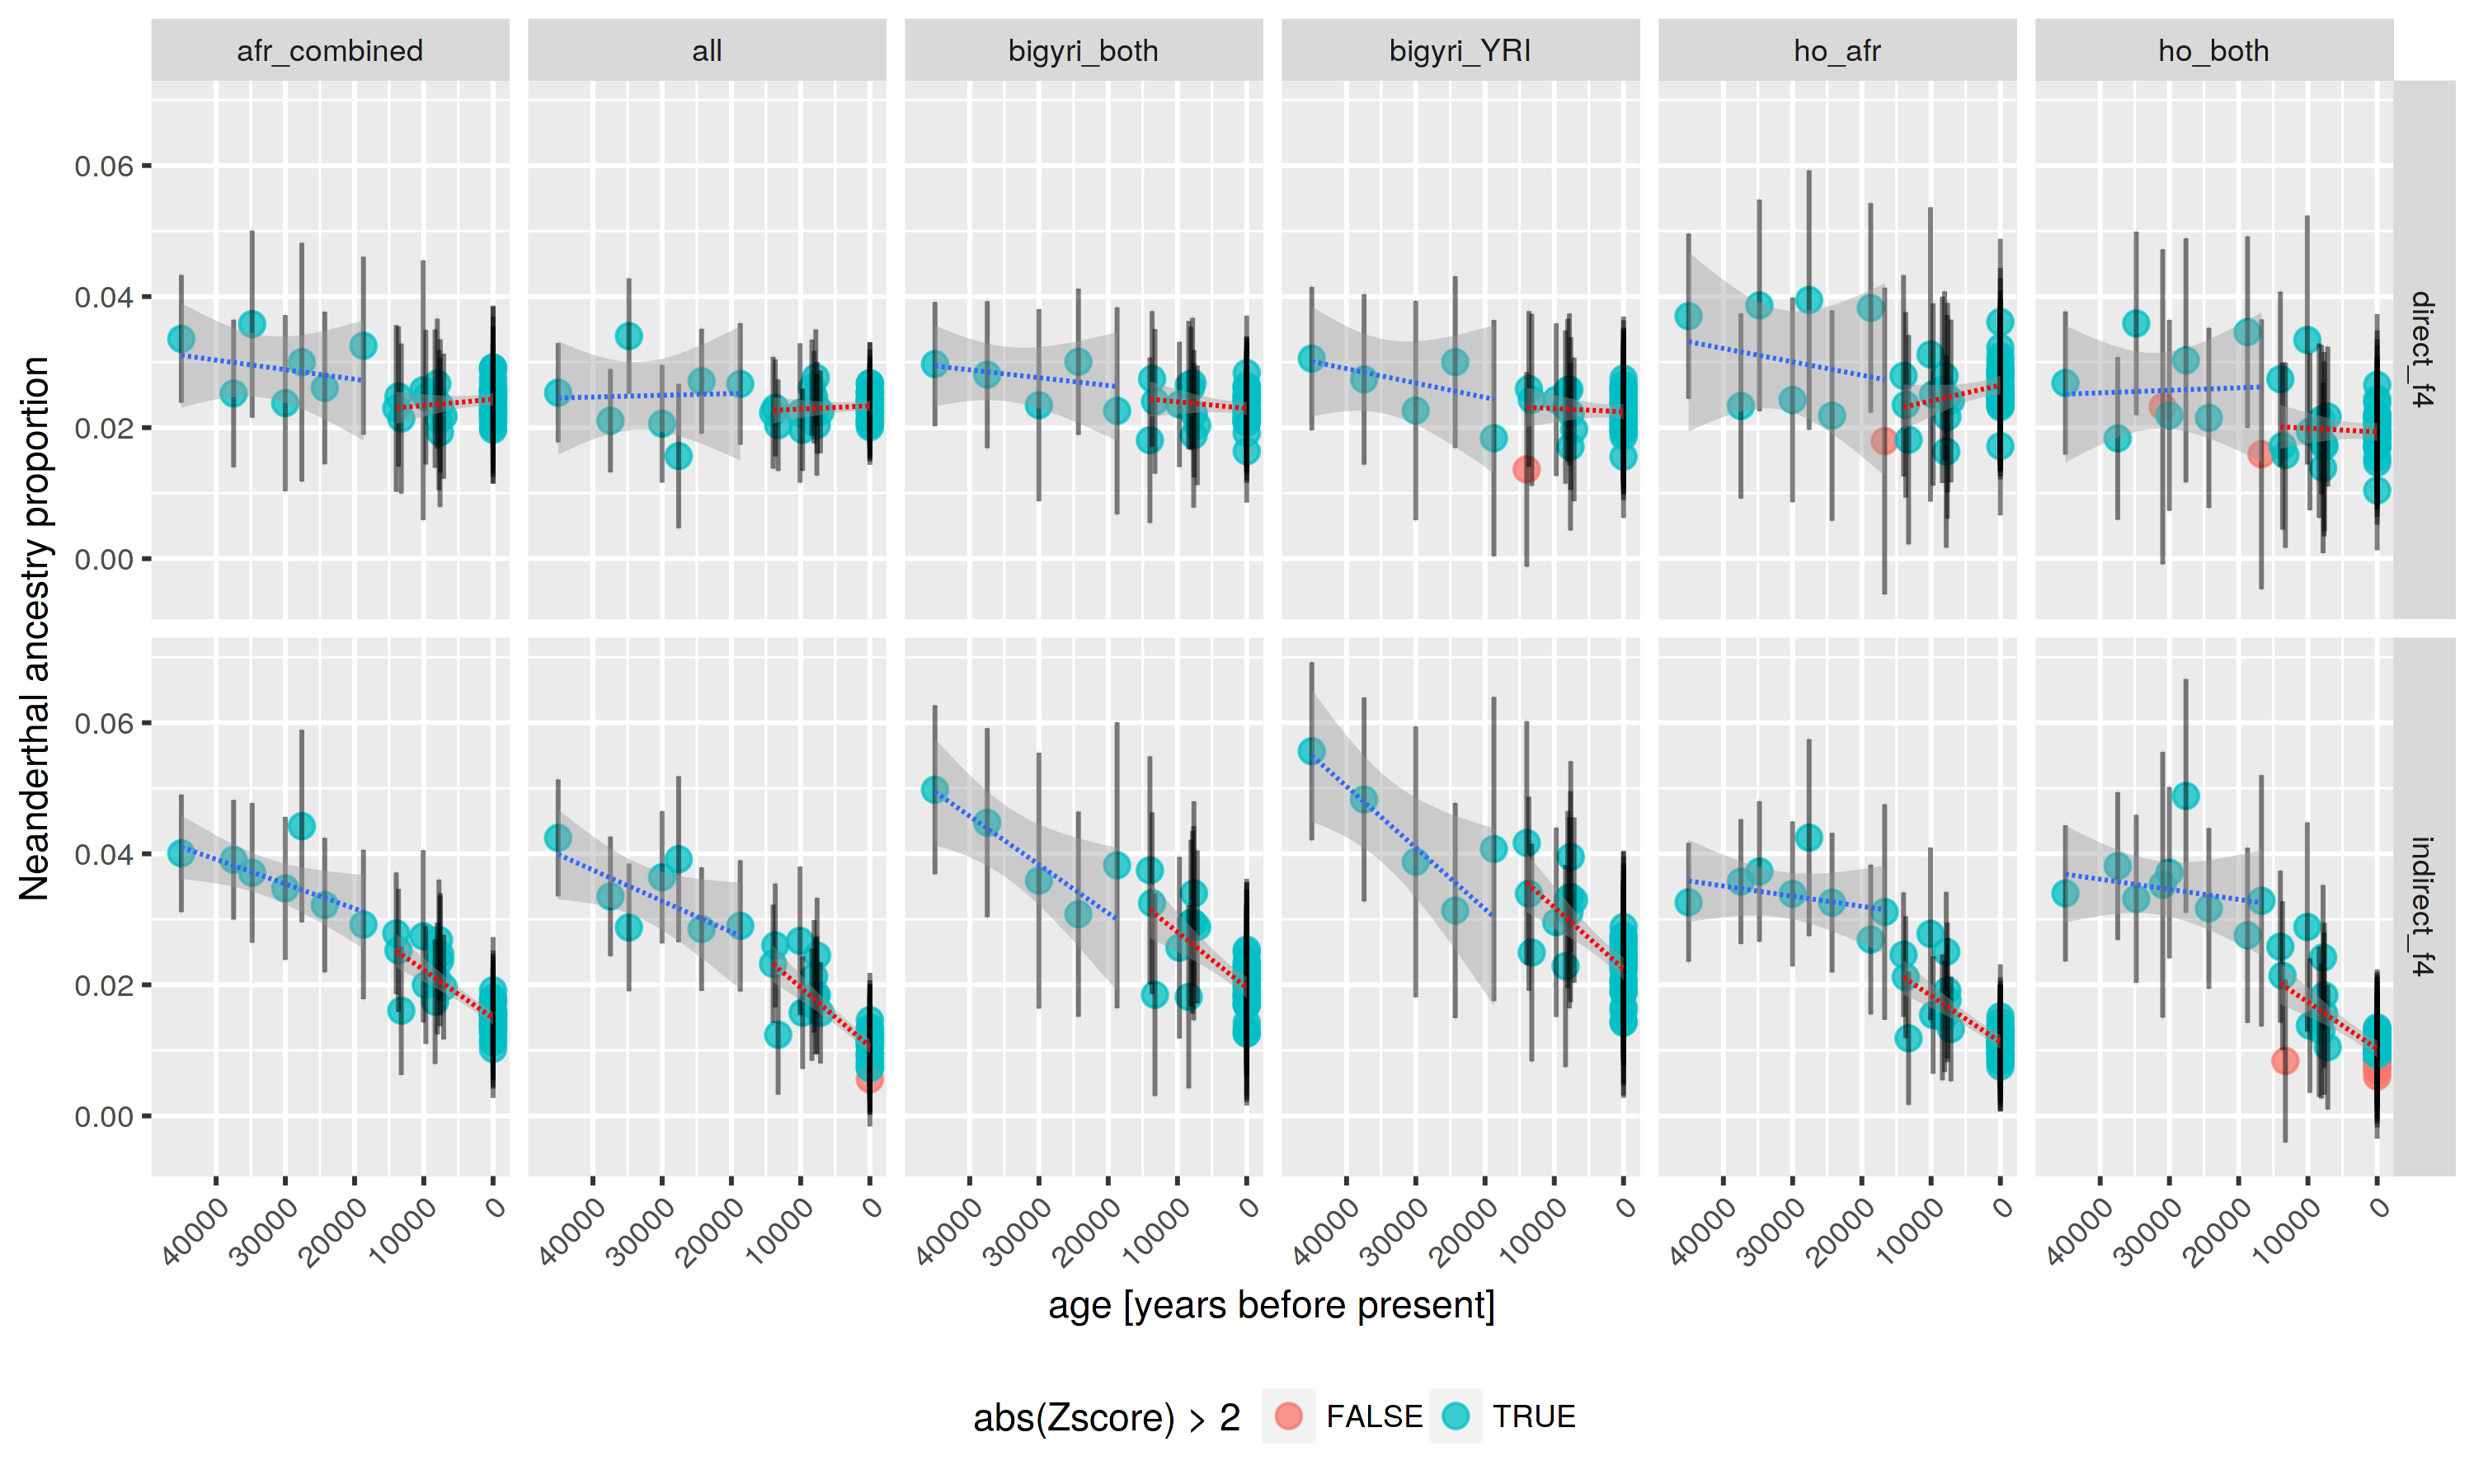

In [30]:
options(repr.plot.width=10, repr.plot.height=6, repr.plot.res = 300)

f4 %>% filter(
    pop %in% c("EMH", "WestEurasia"),
    !X %in% near_east,
    sites != "ho_nonafr") %>%
{
ggplot(., aes(age, alpha)) +
    geom_point(aes(color = abs(Zscore) > 2), alpha=3/4, size=3) +
    geom_errorbar(aes(ymin=alpha - 2 * stderr, ymax=alpha + 2 * stderr), alpha = 1/2) +
#    geom_smooth(aes(weight=snp_count), data=., method="lm", linetype=2, size=0.5) +
    geom_smooth(aes(weight=snp_count), data=filter(., age > 15000), method="lm", linetype=2, size=0.5) +
    geom_smooth(aes(weight=snp_count), data=filter(., age < 15000), color = "red", method="lm", linetype=2, size=0.5) +
    xlab("age [years before present]") + ylab("Neanderthal ancestry proportion") +
    xlim(47000, 0) +
    facet_grid(stat ~ sites) +
    theme(legend.position = "bottom", axis.text.x = element_text(angle = 45, hjust = 1))
}

In [67]:
saveRDS(f4, "../paper/rds/f4_nea.rds")

In [26]:
f4 <- readRDS("../paper/rds/f4_nea.rds")

pop,mu
EastAsia,0.02381918
WestEurasia,0.02253769


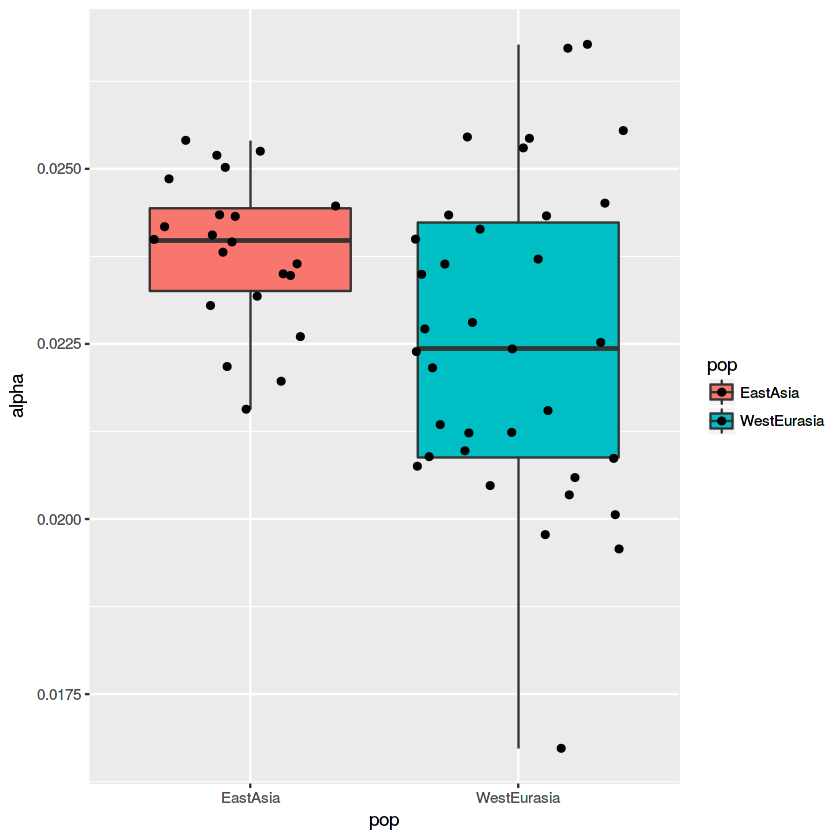

In [24]:
filter(f4, pop %in% c("WestEurasia", "EastAsia"), stat == "direct_f4", sites == "all") %>%
group_by(pop) %>% summarise(mu = mean(alpha))

filter(f4, pop %in% c("WestEurasia", "EastAsia"), stat == "direct_f4", sites == "all") %>%
ggplot(aes(pop, alpha, fill = pop)) + geom_boxplot() + geom_jitter()

In [60]:
near_east <-
    readRDS("../paper/rds/near_east_proportions.rds") %>% filter(B == "Levant_N", A == "Yemenite_Jew") %>%
    select(X, near_east_alpha = alpha, pop)

In [61]:
nea <- filter(f4, stat == "direct_f4", sites == "afr_combined") %>% select(X, nea_alpha = alpha, pop)

Joining, by = c("X", "pop")


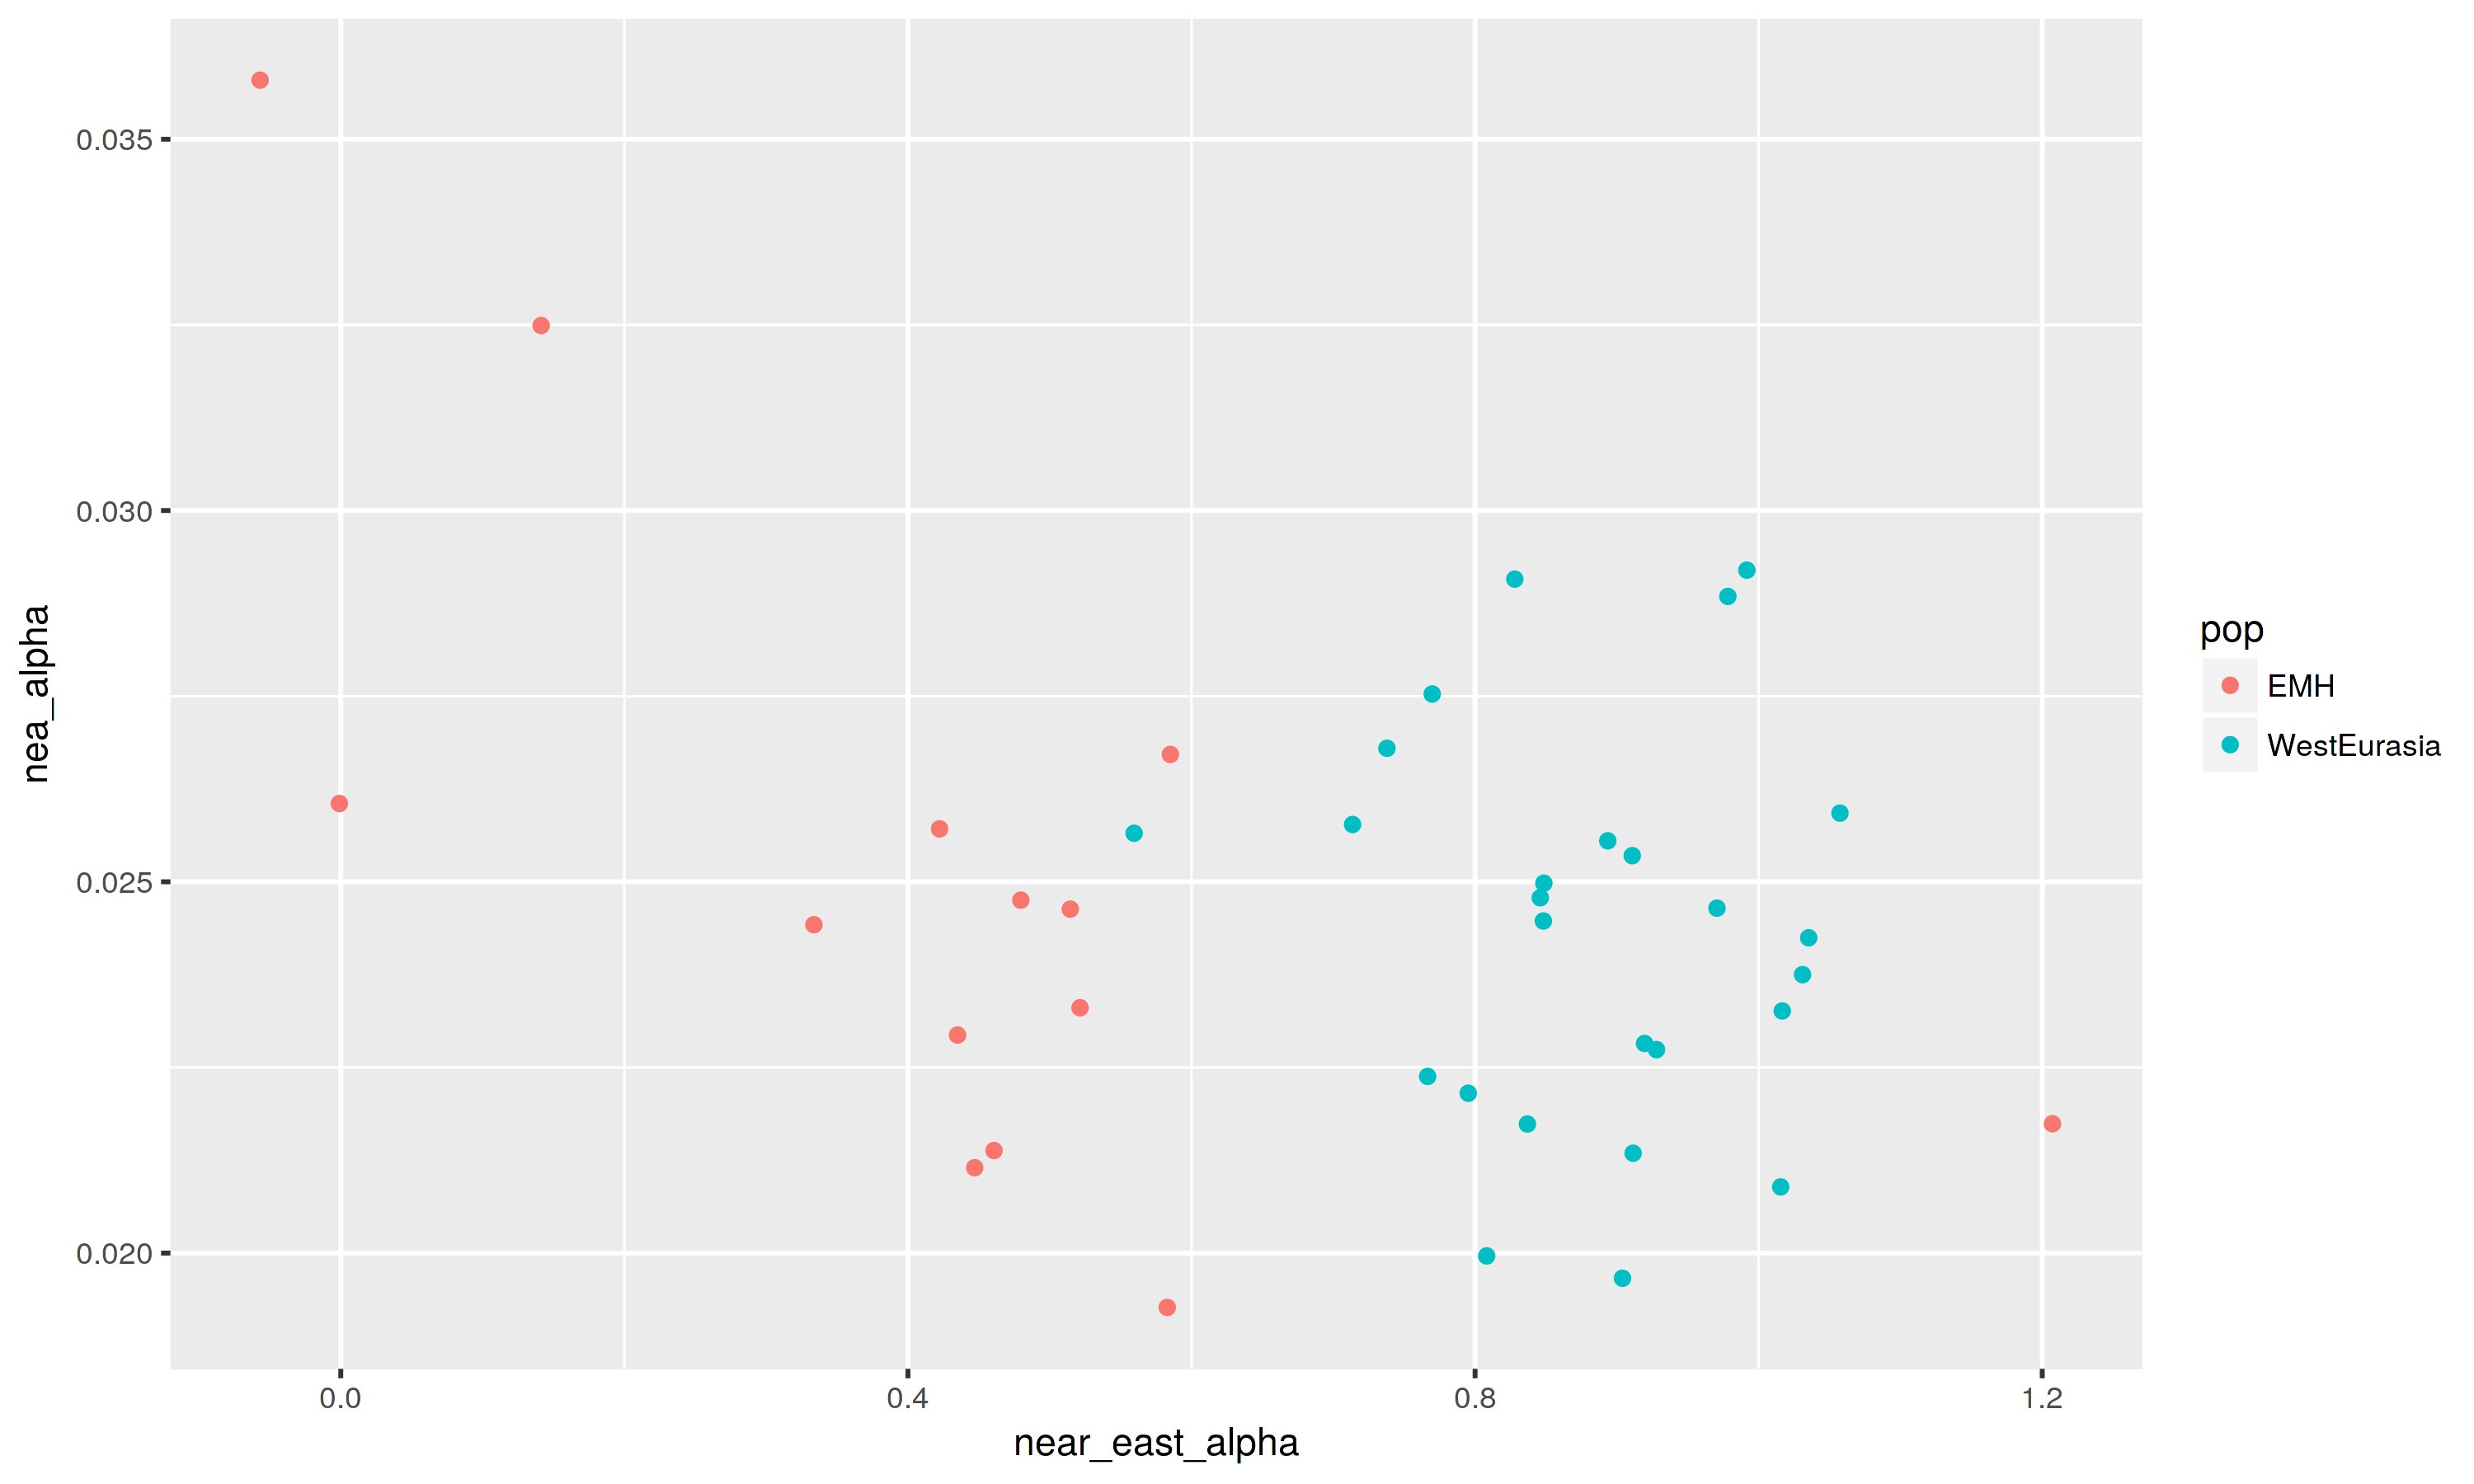

In [62]:
inner_join(near_east, nea) %>%
ggplot(aes(near_east_alpha, nea_alpha, color = pop)) + geom_point()

In [48]:
select(f4, X, alpha, sites, stat, pop) %>%
spread(sites, alpha) %>%
filter(pop == "WestEurasia") %>% head

X,stat,pop,all,BigYRI,combinedAFR,HO_afr,HO_both,HO_nonafr
Abkhasian,direct_f4,WestEurasia,0.020169,0.022835,0.024822,0.027719,0.013927,0.000265
Abkhasian,indirect_f4,WestEurasia,0.007785,0.017027,0.012040,0.009266,0.009604,0.010488
Adygei,direct_f4,WestEurasia,0.024637,0.028258,0.030615,0.034050,0.019964,0.006010
Adygei,indirect_f4,WestEurasia,0.007858,0.014262,0.011080,0.009311,0.008501,0.006424
Albanian,direct_f4,WestEurasia,0.025902,0.030206,0.032245,0.035219,0.025011,0.014900
Albanian,indirect_f4,WestEurasia,0.008915,0.019866,0.013314,0.009670,0.006000,-0.003454


Warning message:
“Removed 4 rows containing missing values (geom_point).”

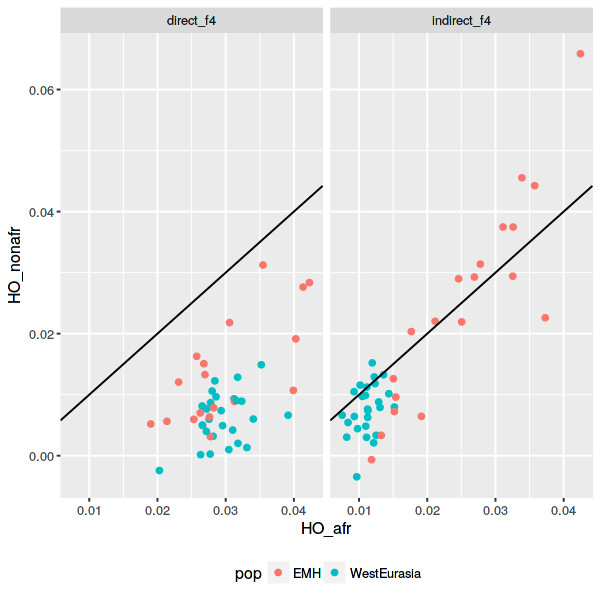

In [49]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 100)

select(f4, X, alpha, sites, stat, pop) %>%
spread(sites, alpha) %>%
filter(pop %in% c("EMH", "WestEurasia")) %>% 
ggplot(aes(HO_afr, HO_nonafr, color = pop)) + geom_point() + facet_grid(. ~ stat) + geom_abline(slope=1) +
theme(legend.position = "bottom")